1.Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?



mean of no default (0) 178099.72607430234 median of no default (0) 150000.0
mean of default (1) 130109.65641952984 median of default (1) 90000.0


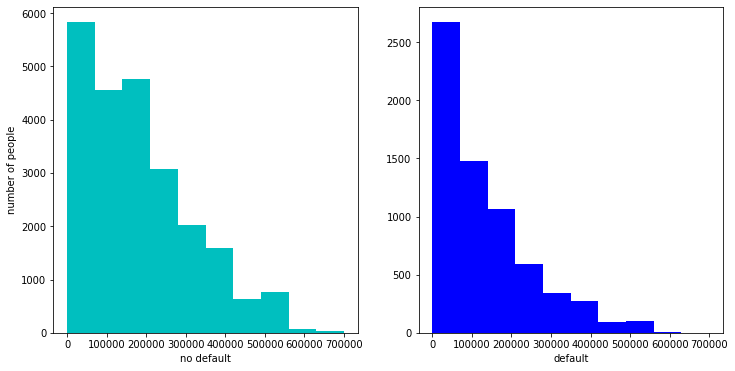

In [79]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.stats.weightstats import *
import scipy
import statsmodels
import matplotlib.pyplot as plt
from itertools import chain
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib.pyplot import figure


credit = pd.read_csv('credit_card_default_analysis.csv')
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.hist(credit[credit.default == 0].LIMIT_BAL, color = 'c', range = (0,700000))
plt.xlabel('no default')
plt.ylabel('number of people')

plt.subplot(1,2,2)
plt.hist(credit[credit.default == 1].LIMIT_BAL, color = 'b', range = (0,700000))
plt.xlabel('default')

print(f'mean of no default (0) {credit[credit.default == 0].LIMIT_BAL.mean()}', 
f'median of no default (0) {credit[credit.default == 0].LIMIT_BAL.median()}')
print(f'mean of default (1) {credit[credit.default == 1].LIMIT_BAL.mean()}', 
f'median of default (1) {credit[credit.default == 1].LIMIT_BAL.median()}')

проверить гипотезу:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

H0: медианные значения равны      
H1: медианные значения раличаются

In [2]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

    
LIMIT_BAL_0 = credit[credit.default == 0].LIMIT_BAL.values
LIMIT_BAL_1 = credit[credit.default == 1].LIMIT_BAL.values

np.random.seed(0)

LIMIT_BAL_0_median_scores = list(map(np.median, get_bootstrap_samples(LIMIT_BAL_0, 1000)))
LIMIT_BAL_1_median_scores = list(map(np.median, get_bootstrap_samples(LIMIT_BAL_1, 1000)))

print("95% confidence interval for the no default's limit_bal:",  stat_intervals(LIMIT_BAL_0_median_scores, 0.05))
print("95% confidence interval for the default's limit_bal:",  stat_intervals(LIMIT_BAL_1_median_scores, 0.05))

95% confidence interval for the no default's limit_bal: [150000. 150000.]
95% confidence interval for the default's limit_bal: [80000. 90000.]


Вывод: маленькие кредиты возвращаются менее охотно

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 
     Двухвыборочный непараметрический критерий для независимых выборок (перестановочный).

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [3]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)


def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]


def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr


def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
    
print("p-value: %f" % permutation_test(LIMIT_BAL_0, LIMIT_BAL_1, max_permutations = 1000))

p-value: 0.001000


Вывод: отвергаем нулевую гипотизу на уровне значимости 0.05 о том, что распределения выборок равны.

2.Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

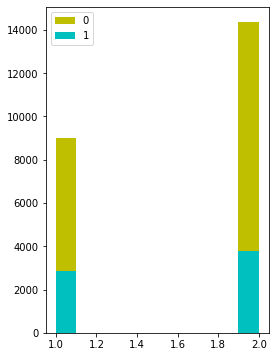

доля мужчина, не вернувщих кредит (от всех мужчин, взявших кредит)
0.2416722745625841
доля женщина, не вернувших кредит (от всех женщин, взявших кредит)
0.20776280918727916


/tmp/ipykernel_4560/548434096.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(credit[credit['SEX'] == 1][credit['default'] == 1]['default'].count()/
/tmp/ipykernel_4560/548434096.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(credit[credit['SEX'] == 2][credit['default'] == 1]['default'].count()/


In [78]:
plt.figure(figsize=(4,6))

plt.hist(credit.SEX.loc[credit['default']  == 0], color = 'y')
plt.hist(credit.SEX.loc[credit['default']  == 1], color = 'c')
plt.legend('01')
plt.show()

print('доля мужчина, не вернувщих кредит (от всех мужчин, взявших кредит)')
print(credit[credit['SEX'] == 1][credit['default'] == 1]['default'].count()/
      credit[credit['SEX'] == 1]['SEX'].count())
print('доля женщина, не вернувших кредит (от всех женщин, взявших кредит)')
print(credit[credit['SEX'] == 2][credit['default'] == 1]['default'].count()/
      credit[credit['SEX'] == 2]['SEX'].count())

H0: гендер не влияет на дефолт      
H1: гендер влияет на дефолт  

In [5]:
from statsmodels.stats.proportion import proportion_confint


men_def_or_no_def = credit[credit['SEX'] == 1].default
women_def_or_no_def = credit[credit['SEX'] == 2].default

conf_interv_men_def = proportion_confint(men_def_or_no_def.sum(),
                        men_def_or_no_def.shape[0],
                       method='wilson')
conf_interv_women_def = proportion_confint(women_def_or_no_def.sum(),
                       women_def_or_no_def.shape[0],
                       method='wilson')
print(f'мужчины c дефолтом {conf_interv_men_def}')
print(f'женщины c дефолтом {conf_interv_women_def}')

мужчины c дефолтом (0.2340610359763117, 0.24945040997857762)
женщины c дефолтом (0.20191659085963207, 0.21373296513459847)


Вывод: соотношение данных согласуется с гистограммами и с результатами наивных расчётов. Интервалы не пересекаются

Доверительный интервал для разности долей (независимые выборки):

In [6]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)


def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))


def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    
    
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(men_def_or_no_def, women_def_or_no_def))
print(f'p-value: {proportions_diff_z_test(proportions_diff_z_stat_ind(men_def_or_no_def, women_def_or_no_def))}')

95% confidence interval for a difference between proportions: [0.024207, 0.043612]
p-value: 4.472866521609831e-12


Н0 о незначимости гендера для кредитного скоринга отвергается на уровне значимости 0.05

3.Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг? наоборт, не отдаст долг?
      
 0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных 

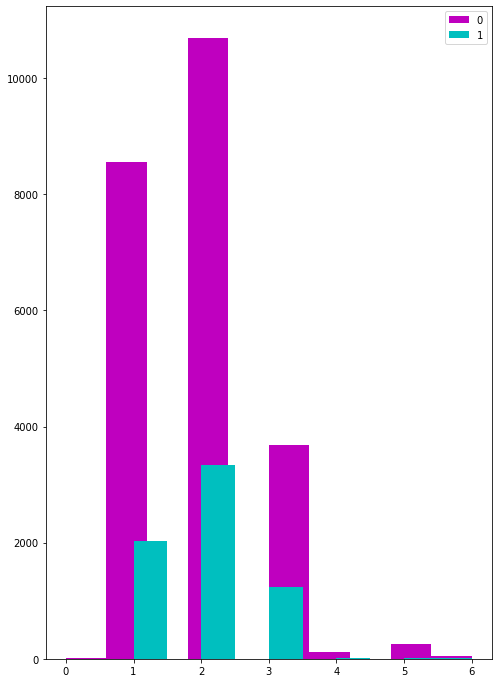

In [7]:
plt.figure(figsize=(8,12))
plt.hist(credit.EDUCATION.loc[credit['default']  == 0], color = 'm')
plt.hist(credit.EDUCATION.loc[credit['default']  == 1], color = 'c')
plt.legend('01')
plt.show()

Судя по гистограмме вероятность дефолта минимальна, если заемщик имеет бакалаврску степень. А Если имеет магистерскую степень, то вероятность выше? Отмасштабируем значения признаков. 

Таблицу сопряженности "образование" на "возврат долга", где значением ячейки является разность между наблюдаемым и ожидаемым количеством человек. 

In [8]:
for i in range(7):
    delta = credit[credit['default'] == 0][credit['EDUCATION'] == i].shape[0] - credit[credit['default'] == 1][credit['EDUCATION'] == i].shape[0]
    print(i, delta, credit[credit.EDUCATION == i].shape[0])

0 14 14
1 6513 10585
2 7370 14030
3 2443 4917
4 109 123
5 244 280
6 35 51


/tmp/ipykernel_4560/2343435865.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delta = credit[credit['default'] == 0][credit['EDUCATION'] == i].shape[0] - credit[credit['default'] == 1][credit['EDUCATION'] == i].shape[0]


In [58]:
normalize_edu_list = []
for i in range(7):
    new_del = credit[(credit.EDUCATION == i) & (credit.default == 0)].shape[0]/credit[(credit.EDUCATION == i)].shape[0]
    normalize_edu_list.append(new_del)
    print(i, new_del)

0 1.0
1 0.8076523382144544
2 0.7626514611546685
3 0.7484238356721579
4 0.943089430894309
5 0.9357142857142857
6 0.8431372549019608


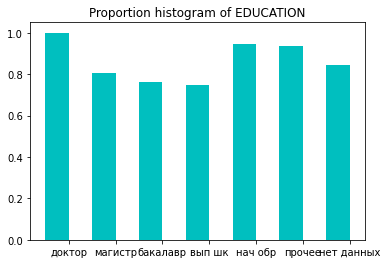

In [69]:
labels = ['доктор', 'магистр', 'бакалавр', 'вып шк', 'нач обр', 'прочее', 'нет данных']
x = np.arange(len(labels))  
width = 0.5  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normalize_edu_list, width, color='c')
ax.set_title('Proportion histogram of EDUCATION')
ax.set_xticks(x, labels)
plt.show()

Вероятность возврата кредита при наличии начального образования выше, чем если это выпускник школы?

H0: нет связи между вероятностью дефолта и уровнем образования

H1: есть

In [60]:
from scipy.stats import chi2_contingency

obs_edu_no_def = list(credit.EDUCATION.loc[credit['default'] == 0].values)
obs_freq_edu_no_def = np.bincount(obs_edu_no_def)
obs_edu_def = list(credit.EDUCATION.loc[credit['default'] == 1].values)
obs_freq_edu_def = np.bincount(obs_edu_def)
obs_freq = np.row_stack((obs_freq_edu_def, obs_freq_edu_no_def))

print("p-value: ", scipy.stats.chi2_contingency(obs_freq)[1])

p-value:  1.2332626245415958e-32


H0 отвергается на уровне значимости 0.05, следовательно есть связь между вероятностью дефолта и уровнем образования 

4.Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных

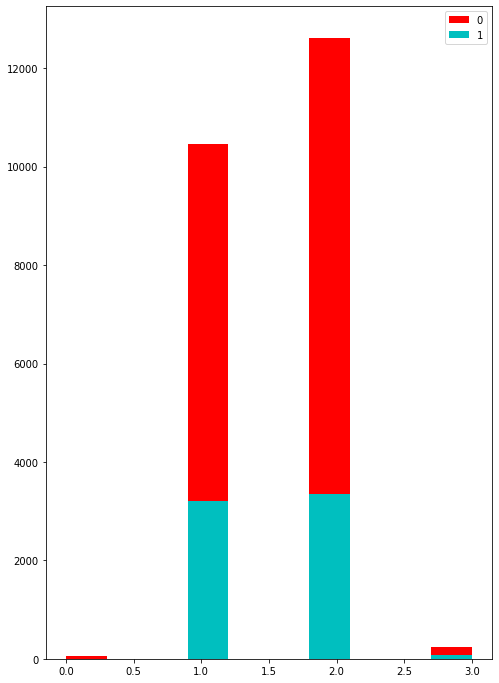

In [77]:
plt.figure(figsize=(8,12))
plt.hist(credit.MARRIAGE.loc[credit['default']  == 0], color = 'r')
plt.hist(credit.MARRIAGE.loc[credit['default']  == 1], color = 'c')
plt.legend('01')
plt.show()

Таблицу сопряженности "семейное положение" на "возврат долга", где значением ячейки является разность между наблюдаемым и ожидаемым количеством человек. 

In [55]:
for i in range(4):
    delta = credit[(credit.MARRIAGE == i) & (credit.default == 0)].shape[0] - \
            credit[(credit.MARRIAGE == i) & (credit.default == 1)].shape[0]
    print(i, delta, credit[credit.MARRIAGE == i].shape[0])

0 44 54
1 7247 13659
2 9282 15964
3 155 323


In [66]:
normalize_marriage_list = []
for i in range(4):
    new_del = credit[(credit.MARRIAGE  == i) & (credit.default == 0)].shape[0]/credit[(credit.MARRIAGE == i)].shape[0]
    normalize_marriage_list.append(new_del)
    print(i, new_del)

0 0.9074074074074074
1 0.7652829636137345
2 0.7907166123778502
3 0.739938080495356


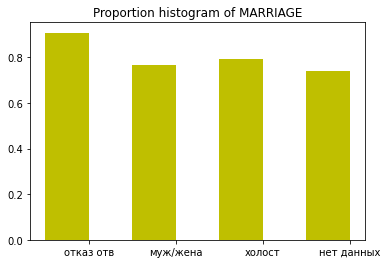

In [72]:
labels = ['отказ отв', 'муж/жена', 'холост', 'нет данных']
x = np.arange(len(labels))  
width = 0.5  
fig, ax = plt.subplots()
rects2 = ax.bar(x - width/2, normalize_marriage_list, width, color='y')
ax.set_title('Proportion histogram of MARRIAGE')
ax.set_xticks(x, labels)
plt.show()

H0: нет связи между вероятностью дефолта и семейным положением

H1: есть

In [74]:
obs_mar_no_def = list(credit.MARRIAGE.loc[credit['default'] == 0].values)
obs_freq_mar_no_def = np.bincount(obs_mar_no_def)
obs_mar_def = list(credit.MARRIAGE.loc[credit['default'] == 1].values)
obs_freq_mar_def = np.bincount(obs_mar_def)
obs_freq = np.row_stack((obs_freq_mar_def, obs_freq_mar_no_def))

print("p-value: ", scipy.stats.chi2_contingency(obs_freq)[1])

p-value:  8.825862457577375e-08


H0 отвергается на уровне значимости 0.05, следовательно есть связь между вероятностью дефолта и семейным положением

5.Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

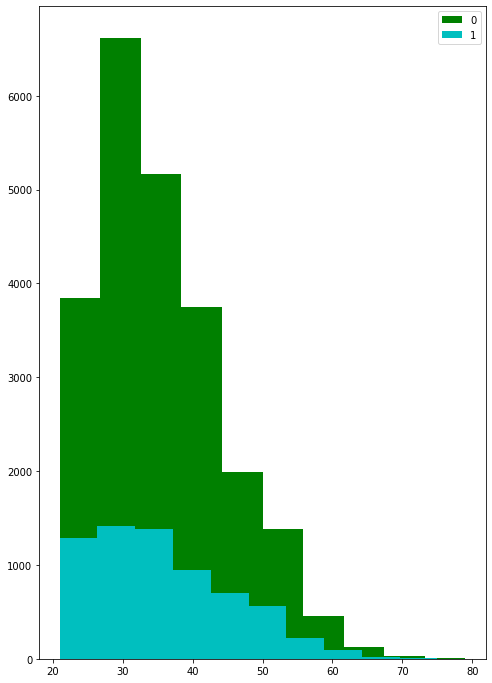

mean of no default (0) 35.417265879130284 median of no default (0) 34.0
mean of default (1) 35.72573839662447 median of default (1) 34.0


In [81]:
plt.figure(figsize=(8,12))
plt.hist(credit.AGE.loc[credit['default']  == 0], color = 'g')
plt.hist(credit.AGE.loc[credit['default']  == 1], color = 'c')
plt.legend('01')
plt.show()

print(f'mean of no default (0) {credit[credit.default == 0].AGE.mean()}', 
f'median of no default (0) {credit[credit.default == 0].AGE.median()}')
print(f'mean of default (1) {credit[credit.default == 1].AGE.mean()}', 
f'median of default (1) {credit[credit.default == 1].AGE.median()}')

проверить гипотезу:   a)  о равенстве медианных значений возрастов людей

H0: медианные значения равны      
H1: медианные значения раличаются

In [85]:
AGE_0 = credit[credit.default == 0].AGE.values
AGE_1 = credit[credit.default == 1].AGE.values

np.random.seed(0)

AGE_0_median_scores = list(map(np.median, get_bootstrap_samples(AGE_0, 1000)))
AGE_1_median_scores = list(map(np.median, get_bootstrap_samples(AGE_1, 1000)))

print("95% confidence interval for the no default's age:",  stat_intervals(AGE_0_median_scores, 0.05))
print("95% confidence interval for the default's age:",  stat_intervals(AGE_1_median_scores, 0.05))

95% confidence interval for the no default's age: [34. 34.]
95% confidence interval for the default's age: [34. 35.]


Вывод: в обеих категориях преобладает один и тот же возраст

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 
     Двухвыборочный непараметрический критерий для независимых выборок (перестановочный).

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [86]:
print("p-value: %f" % permutation_test(AGE_0, AGE_1, max_permutations = 1000))

p-value: 0.014000


Вывод: отвергаем нулевую гипотизу на уровне значимости 0.05 о том, что распределения выборок равны.